# Simulation

## Multi-armed bandits task

We consider the case in which a participant makes a series of $T$ choices between $K$ slot machines, or `one-armed bandits', to try to maximize their earnings.  If played on trial $t$, each slot machine, $k$, pays out a reward, $r_t$, which is 1 with reward probability, $\mu^k_t$, and otherwise 0.  The reward probabilities are different for each slot machine and are initially unknown to the subject. In the simplest version of the task, the reward probabilities are fixed over time.

The three experimental parameters of this task are: the number of trials, $T$, the number of slot machines, $K$, and the reward probabilities of the different options, $\mu^k_t$, which may or may not change over time. 

In [1]:
% We will fix mu throughout (this also means we implicitly fix K = 2 also)
mu = [0.2 0.8]; % option 1 pays out with 20% probability, option 2 with 80% probability

## Model 1: Random responding
In the first model, we assume that participants do not engage with the task at all and simply press buttons at random, perhaps with a bias for one option over the other. Such random behavior is not uncommon in behavioral experiments, especially when participants have no external incentives for performing well. Modeling such behavior can be important if we wish to identify such `checked out' individuals in a quantitative and reproducible manner, either for exclusion or to study the checked-out behavior itself.  To model this behavior we assume that participants choose between the two options randomly, perhaps with some overall bias for one option over the other.  This bias is captured with a parameter $b$ (which is between 0 and 1) such that the probability of choosing the two options is
\begin{equation}
\label{eq:cp1}
    p^1_t = b \quad \mbox{and}\quad p^2_t = 1-b
\end{equation}
Thus, for two bandits, the random responding model has just one free parameter, controlling the overall bias for option 1 over option 2, $\theta_1 = b$.

In [2]:
%%file simulate_M1random_v1.m

% Specify the random responding model as a function
function [a, r] = simulate_M1random_v1(T, mu, b)

for t = 1:T
    
    % compute choice probabilities
    p = [b 1-b];
    
    % make choice according to choice probababilities
    a(t) = choose(p);
    
    % generate reward based on choice
    r(t) = rand < mu(a(t));
    
end


Created file '/Users/bob/Work/Teaching/2019_MIND_SummerSchool/notebooks/simulate_M1random_v1.m'.


In [3]:
% simulate the random responding model
[a,r] = simulate_M1random_v1(50, mu, 0.5);

In [4]:
%%file plot_simulation.m

% make a function to plot the output of the simulations
function plot_simulation(ax, a, r)
axes(ax); 
hold on;
time = 1:length(a);
% plot actions
plot(time, a,'.-', 'color', [1 1 1]*0.75, 'markersize', 10)
% color rewarded choice red
plot(time(r==1), a(r==1), '.', 'markersize', 10, 'color', 'r')
ylim([0.8 2.2])
set(gca,'ytick',[1 2],'tickdir','out','fontsize',18)
xlabel('time step')
ylabel('choice')

Created file '/Users/bob/Work/Teaching/2019_MIND_SummerSchool/notebooks/plot_simulation.m'.


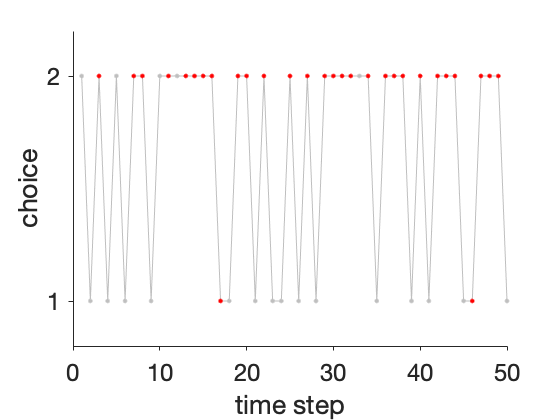

In [5]:
% plot the output
plot_simulation(gca, a, r)


## Model 2: Noisy win-stay-lose-shift
The win-stay-lose-shift model is one of the simplest models that adapts its behavior according to feedback. Consistent with the name, the model repeats rewarded actions and switches away from unrewarded actions. In the noisy version of the model, the win-stay-lose-shift rule is applied probabilistically, such that the model applies the win-stay-lose-shift rule with probability $1-\epsilon$, and chooses randomly with probability $\epsilon$. In the two-bandit case,  the probability of choosing option $k$ is
\begin{equation}
    p^k_t = \left\{
        \begin{array}{cc}
             1- \epsilon/2 
             & \mbox{if } (c_{t-1} = k \mbox{ and } r_{t-1} = 1) \mbox{ OR } (c_{t-1} \ne k \mbox{ and } r_{t-1} = 0)\\
             \epsilon/2 
             & \mbox{if } (c_{t-1} \ne k \mbox{ and } r_{t-1} = 1) \mbox{ OR } (c_{t-1} = k \mbox{ and } r_{t-1} = 0)
        \end{array}
    \right.
\end{equation}
where $c_t=1,2$ is the choice at trial $t$, and $r_t=0,1$ the reward at trial $t$. While more complex to implement, this model still only has one free parameter, the overall level of randomness, $\theta_2 = \epsilon$.


In [6]:
%%file simulate_M2WSLS_v1.m

function [a, r] = simulate_M2WSLS_v1(T, mu, epsilon)

% last reward/action (initialize as nan)
rLast = nan;
aLast = nan;

for t = 1:T
    
    % compute choice probabilities
    if isnan(rLast)
        
        % first trial choose randomly
        p = [0.5 0.5];
        
    else
        
        % choice depends on last reward
        if rLast == 1
            
            % win stay (with probability 1-epsilon)
            p = epsilon/2*[1 1];
            p(aLast) = 1-epsilon/2;
            
        else
            
            % lose shift (with probability 1-epsilon)
            p = (1-epsilon/2) * [1 1];
            p(aLast) = epsilon / 2;
            
        end
    end
    
    % make choice according to choice probababilities
    a(t) = choose(p);
    
    % generate reward based on choice
    r(t) = rand < mu(a(t));
    
    
    aLast = a(t);
    rLast = r(t);
end



Created file '/Users/bob/Work/Teaching/2019_MIND_SummerSchool/notebooks/simulate_M2WSLS_v1.m'.


In [7]:
[a, r] = simulate_M2WSLS_v1(50, mu, 0.1);

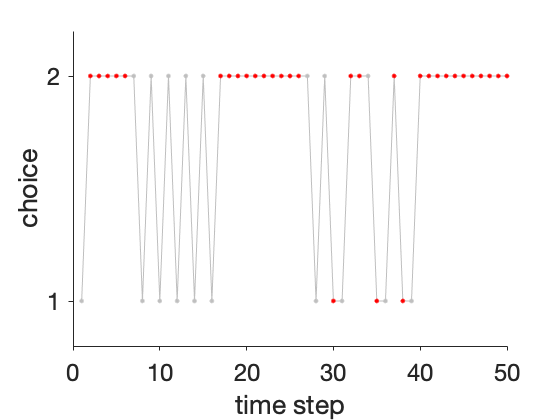

In [8]:
% plot the output
plot_simulation(gca, a, r)

## Model 3: Rescorla Wagner 
In this model, participants first learn the expected value of each slot machine based on the history of previous outcomes and then use these values to make a decision about what to do next.  A simple model of learning is the Rescorla-Wagner learning rule (Rescorla & Wagner, 1972) whereby the value of option $k$, $Q^k_t$ is updated in response to reward $r_t$ according to 
\begin{equation}
\label{eq:learning1}
    Q^k_{t+1} = Q^k_t + \alpha (r_t - Q^k_t)
\end{equation}
where $\alpha$ is the learning rate, which takes a value between 0 and 1 and captures the extent to which the prediction error, $(r_t - Q^k_t)$, updates the value.  For simplicity, we assume that the initial value, $Q^k_0$, is zero, although it is possible to treat the $Q^k_0$ as a free parameter of the model.

A simple model of decision making is to assume that participants use the options' values to guide their decisions, choosing the most valuable option most frequently, but occasionally making 'mistakes' (or exploring) by choosing a low value option.  One choice rule with these properties is known as the 'softmax' choice rule, which chooses option $k$ with probability 
\begin{equation}
\label{eq:decision1}
    p^k_t = \frac{\exp(\beta Q^k_t)}{\sum_{i=1}^K \exp(\beta Q^i_t)}
\end{equation}
where $\beta$ is the 'inverse temperature' parameter that controls the level of stochasticity in the choice, ranging from $\beta = 0$ for completely random responding and $\beta = \infty$ for deterministically choosing the highest value option.

Combining the learning and decision rules gives a simple model of decision making in this task with two free parameters: the learning rate, $\alpha$, and the inverse temperature $\beta$.  That is, in our general notation, for this model $\theta_3 = (\alpha, \beta)$.

In [9]:
%%file simulate_M3RescorlaWagner_v1.m

function [a, r, Q_stored] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta)

Q = [0.5 0.5];

for t = 1:T
    
    % store values
    Q_stored(:,t) = Q;
    
    % compute choice probabilities
    p = exp(beta*Q) / sum(exp(beta*Q));
    
    % make choice according to choice probababilities
    a(t) = choose(p);
    
    % generate reward based on choice
    r(t) = rand < mu(a(t));
    
    % update values
    delta = r(t) - Q(a(t));
    Q(a(t)) = Q(a(t)) + alpha * delta;

end



Created file '/Users/bob/Work/Teaching/2019_MIND_SummerSchool/notebooks/simulate_M3RescorlaWagner_v1.m'.


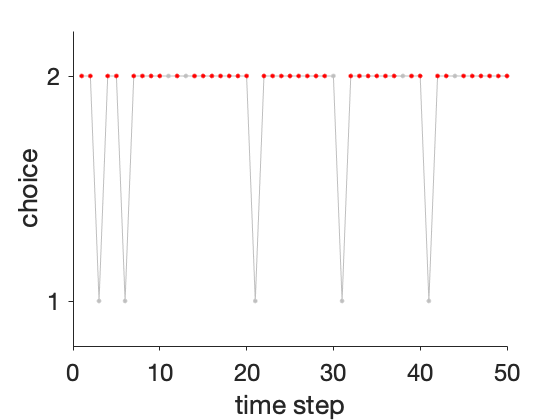

In [13]:
[a, r, Q] = simulate_M3RescorlaWagner_v1(50, mu, 0.1, 5);
plot_simulation(gca, a, r)

In [10]:
%%file plot_values.m

function plot_values(ax, Q, a, mu)
axes(ax); 
hold on;
l = plot(Q');
set(l, 'linewidth', 2)
plot([0 length(a)], [mu(1) mu(1)], 'k--')
plot([0 length(a)], [mu(2) mu(2)], 'k--')
ylim([0 1])
set(ax, 'tickdir', 'out', 'fontsize', 18, 'box', 'off')
ylabel('values')
xlabel('time step')
legend({'option 1' 'option 2'}, 'location', 'southwest')

Created file '/Users/bob/Work/Teaching/2019_MIND_SummerSchool/notebooks/plot_values.m'.


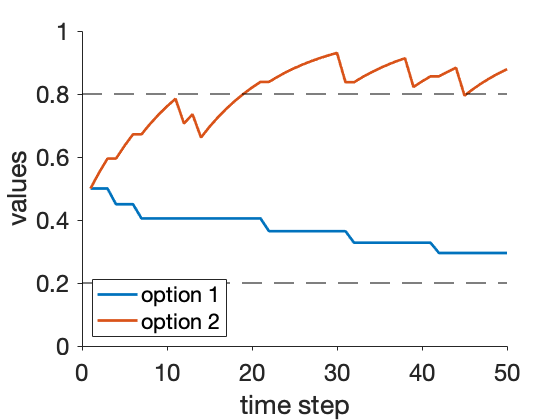

In [14]:
% we can also plot the values from this model
plot_values(gca, Q, a, mu)

## Model 4: Choice kernel 
This model tries to capture the tendency for people to repeat their previous actions. In particular, we assume that participants compute a `choice kernel,' $CK^k_t$, for each action, which keeps track of how frequently they have chosen that option in the recent past.  This choice kernel updates in much the same way as the values in the Rescorla-Wagner rule, i.e. according to
\begin{equation}
\label{eq:CK1}
    CK^k_{t+1} = CK^k_t + \alpha_c (a^k_t - CK^k_t)
\end{equation}
where $a^k_t = 1$ if option $k$ is played on trial $t$, otherwise $a^k_t = 0$, and $\alpha_c$ is the choice-kernel learning rate.  For simplicity we assume that the initial value of the choice kernel is always zero, although, like the initial $Q$-value in the Rescorla-Wagner model, this could be a parameter of the model. Note that with $\alpha_c=1$, this model is very similar to model 2 (win-stay-lose-shift).  From there, we assume that each option is chosen according to
\begin{equation}
\label{eq:CKdecision1}
    p^k_t = \frac{\exp(\beta_c CK^k_t)}{\sum_{i=1}^K \exp(\beta_c CK^i_t)}
\end{equation}
where $\beta_c$ is the inverse temperature associated with the choice kernel.

Combining the choice kernel with the  decision rule gives a simple model of decision making in this task with two free parameters: the choice-kernel learning rate, $\alpha_c$, and the choice-kernel inverse temperature $\beta_c$.  That is, in our general notation, for this model $\theta_4 = (\alpha_c, \beta_c)$.


In [15]:
%%file simulate_M4ChoiceKernel_v1.m

function [a, r, CK_stored] = simulate_M4ChoiceKernel_v1(T, mu, alpha_c, beta_c)

CK = [0 0];

for t = 1:T
    
    % store choice kernel
    CK_stored(:,t) = CK;
    
    % compute choice probabilities
    p = exp(beta_c*CK) / sum(exp(beta_c*CK));
    
    % make choice according to choice probababilities
    a(t) = choose(p);
    
    % generate reward based on choice
    r(t) = rand < mu(a(t));
    
    % update choice kernel
    CK = (1-alpha_c) * CK;
    CK(a(t)) = CK(a(t)) + alpha_c * 1;
            
    
end


Created file '/Users/bob/Work/Teaching/2019_MIND_SummerSchool/notebooks/simulate_M4ChoiceKernel_v1.m'.


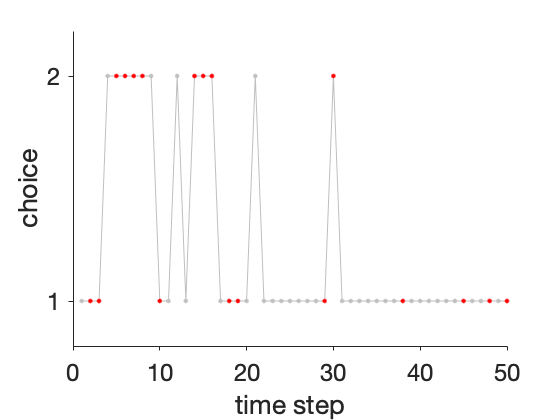

In [16]:
[a, r, CK] = simulate_M4ChoiceKernel_v1(50, mu, 0.1, 5);
plot_simulation(gca, a, r)

In [17]:
%%file plot_kernel.m

function plot_kernel(ax, CK)

axes(ax); hold on;
l = plot(CK');
set(l, 'linewidth', 2)
ylim([0 1])
set(gca, 'tickdir', 'out', 'fontsize', 18, 'box', 'off')
ylabel('choice kernel')
xlabel('time step')
legend({'option 1' 'option 2'}, 'location', 'northwest')

Created file '/Users/bob/Work/Teaching/2019_MIND_SummerSchool/notebooks/plot_kernel.m'.


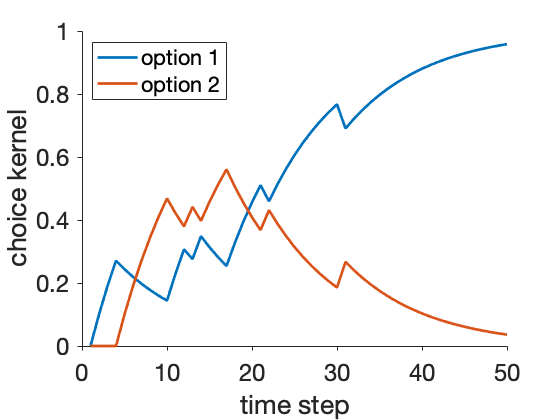

In [18]:
% we can also plot the value of the choice kernel from this model
plot_kernel(gca, CK)

## Model 5: Rescorla Wagner + choice kernel

Finally, our most complex model mixes the reinforcement learning model with the choice kernel model.  In this model, the values update according to the Rescorla-Wagner rule in Model 3, while the choice kernel updates according to the equations for Model 4.  The terms are then combined to compute the choice probabilities as
\begin{equation}
\label{eq:cp5}
    p^k_t = \frac{\exp(\beta Q^k_t + \beta_c CK^k_t)}{\sum_{i=1}^K \exp(\beta Q^i_t + \beta_c CK^i_t)}
\end{equation}
This most complex model has four free parameters, i.e. $\theta_5 = (\alpha, \beta, \alpha_c, \beta_c)$


In [19]:
%%file simulate_M5RWCK_v1.m

function [a, r, Q_stored, CK_stored] = simulate_M5RWCK_v1(T, mu, alpha, beta, alpha_c, beta_c)

Q = [0.5 0.5];
CK = [0 0];

for t = 1:T
    
    Q_stored(:,t) = Q;
    CK_stored(:,t) = CK;
    
    % compute choice probabilities
    V = beta * Q + beta_c * CK;
    p = exp(V) / sum(exp(V));
                
    % make choice according to choice probababilities
    a(t) = choose(p);
    
    % generate reward based on choice
    r(t) = rand < mu(a(t));
    
    % update values
    delta = r(t) - Q(a(t));
    Q(a(t)) = Q(a(t)) + alpha * delta;

    % update choice kernel
    CK = (1-alpha_c) * CK;
    CK(a(t)) = CK(a(t)) + alpha_c * 1;
            
    
end


Created file '/Users/bob/Work/Teaching/2019_MIND_SummerSchool/notebooks/simulate_M5RWCK_v1.m'.


In [20]:
[a, r, Q, CK] = simulate_M5RWCK_v1(50, mu, 0.1, 5, 0.1, 1);

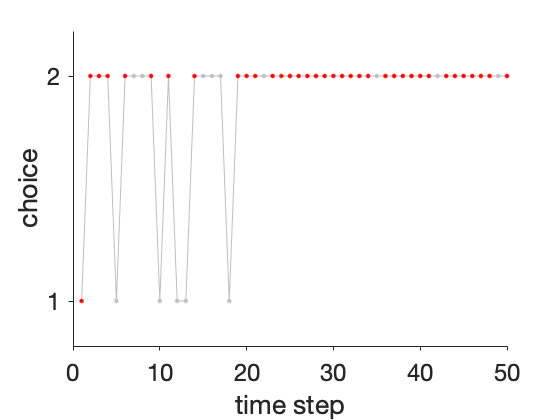

In [21]:
plot_simulation(gca, a, r)

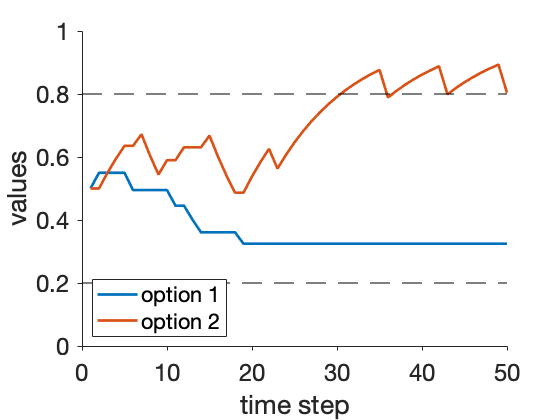

In [23]:
plot_values(gca, Q, a, mu)

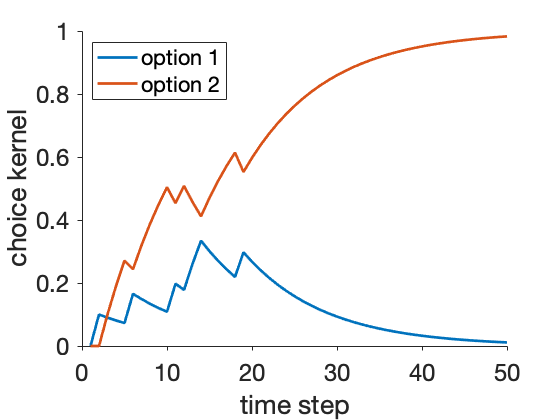

In [24]:
plot_kernel(gca, CK)